Dependencies

In [86]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

Preprocessing

In [87]:
import pathlib

dirname = os.path.dirname(pathlib.Path().resolve())
# filename = "data\housing_price_dataset.csv"
filename = "data/housing_price_dataset.csv"
data = pd.read_csv(os.path.join(dirname, filename))

data.head()


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [88]:
def map_values(value):
    if (value == 'Rural'):
        return 0
    elif (value == 'Suburb'):
        return 1
    elif (value == 'Urban'):
        return 2
    return 3


In [89]:
data['Neighborhood'] = data['Neighborhood'].astype('str').map(map_values)
data['Age'] = 2023 - data['YearBuilt']
data = data.drop('YearBuilt', axis=1)
# data['SquareMeter'] = data['SquareFeet'] * 0.092903
# creates float numbers, and minimal rounding error


In [90]:
from sklearn.model_selection import train_test_split

## Test data
train, test = train_test_split(data, test_size=0.15, random_state=42)

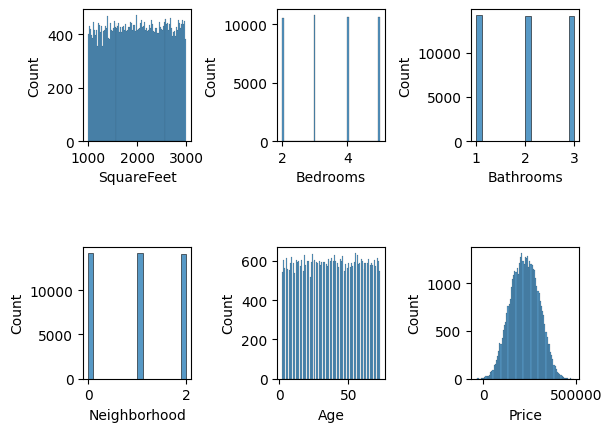

In [91]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.8)
ax = fig.add_subplot(2, 3, 1)
sns.histplot(train["SquareFeet"], bins = 100, ax=ax)
ax = fig.add_subplot(2, 3, 2)
sns.histplot(train["Bedrooms"], ax=ax)
ax = fig.add_subplot(2, 3, 3)
sns.histplot(train["Bathrooms"],ax=ax)
ax = fig.add_subplot(2, 3, 4)
sns.histplot(train["Neighborhood"],ax=ax)
ax = fig.add_subplot(2, 3, 5)
sns.histplot(train["Age"], bins = 100,ax=ax)
ax = fig.add_subplot(2, 3, 6)
sns.histplot(train["Price"], ax=ax)
plt.show()

<Axes: >

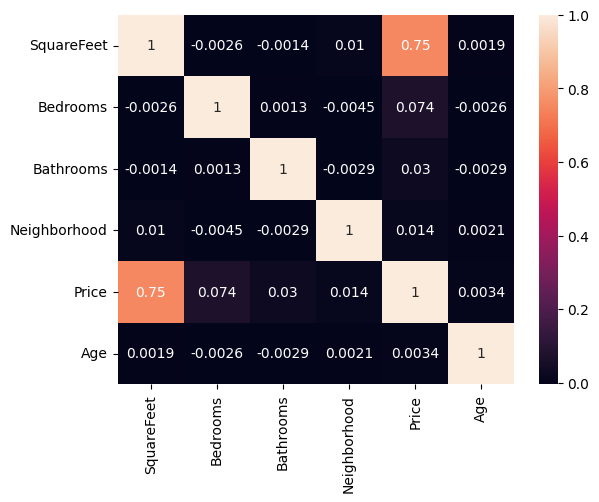

In [92]:
sns.heatmap(train.corr(), annot=True)

In [93]:
# delete faulty data
train.drop(train[train.Price <= 0].index, axis=0, inplace=True)
train.drop_duplicates(keep=False, inplace=True)
train.shape

(42481, 6)

In [94]:
print(train.isna().any(axis=0))
print(train.isnull().any(axis=0))

SquareFeet      False
Bedrooms        False
Bathrooms       False
Neighborhood    False
Price           False
Age             False
dtype: bool
SquareFeet      False
Bedrooms        False
Bathrooms       False
Neighborhood    False
Price           False
Age             False
dtype: bool


In [95]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

sklearn.set_config(transform_output="pandas")
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [96]:
## Validation data
labels = train['Price']
train = train.drop(columns = 'Price', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, test_size=0.15, random_state=42)

Model

In [97]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to 2D PyTorch tensors
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    #print("using ", device)
    return device

device = get_device()

# convert a df to tensor to be used in pytorch
def dataframe_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

X_train = dataframe_to_tensor(X_train)
y_train = dataframe_to_tensor(y_train)
X_valid = dataframe_to_tensor(X_valid)
y_valid = dataframe_to_tensor(y_valid)


y_test = test["Price"]
X_test = test.drop(columns="Price")
X_test = dataframe_to_tensor(X_test)
y_test = dataframe_to_tensor(y_test)

# y_train.reshape((y_train.shape[0], 1))
# y_valid.reshape((y_valid.shape[0], 1))
# y_test.reshape((y_test.shape[0], 1))


train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
test_ds = TensorDataset(X_test, y_test)

In [98]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)

for XX, yy in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {XX.shape}")
    print(f"Shape of y: {yy.shape} {yy.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 5])
Shape of y: torch.Size([64]) torch.float32


In [99]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [100]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [101]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (XX, yy) in enumerate(dataloader):
        # XX = XX.to(device).float()
        yy = yy.to(device).reshape((yy.shape[0], 1))

        # Compute prediction error
        pred = model(XX)
        loss = loss_fn(pred, yy)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(XX)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [102]:
def acc_func(loc_pred, loc_y):
    abs_delta = np.abs(loc_pred - loc_y)
    max_allow = np.abs(0.10 * loc_y)
    return (abs_delta < max_allow).sum().item()

In [103]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for XX, yy in dataloader:
            XX, yy = XX.to(device), yy.to(device)
            # XX = XX.to(device).float()
            yy = yy.reshape((yy.shape[0], 1))
            
            pred = model(XX)
            test_loss += loss_fn(pred, yy).item()
            
            #correct if the difference is < 10%
            correct += acc_func(pred, yy)
            # abs_delta = np.abs(pred - yy)
            # max_allow = np.abs(0.10 * yy)
            # correct += (abs_delta < max_allow).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [104]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.178844  [   64/36108]
loss: 0.012345  [ 6464/36108]
loss: 0.012493  [12864/36108]
loss: 0.011279  [19264/36108]
loss: 0.012118  [25664/36108]
loss: 0.009434  [32064/36108]
Test Error: 
 Accuracy: 31.4%, Avg loss: 0.013063 

Epoch 2
-------------------------------
loss: 0.009945  [   64/36108]
loss: 0.008640  [ 6464/36108]
loss: 0.012546  [12864/36108]
loss: 0.011057  [19264/36108]
loss: 0.012052  [25664/36108]
loss: 0.009372  [32064/36108]
Test Error: 
 Accuracy: 31.5%, Avg loss: 0.013006 

Epoch 3
-------------------------------
loss: 0.009910  [   64/36108]
loss: 0.008585  [ 6464/36108]
loss: 0.012607  [12864/36108]
loss: 0.011027  [19264/36108]
loss: 0.012042  [25664/36108]
loss: 0.009350  [32064/36108]
Test Error: 
 Accuracy: 31.5%, Avg loss: 0.012948 

Epoch 4
-------------------------------
loss: 0.009916  [   64/36108]
loss: 0.008573  [ 6464/36108]
loss: 0.012660  [12864/36108]
loss: 0.010981  [19264/36108]
loss: 0.012025  [25664/3

Grid Search parameters

- number of hidden layers: select 
- units: select
- droupout: 15, 20, 30, 50, 60
- activation function: relu, sigmoid, linear
- learning rate: 3, 5, 20, 50, 80
- number of epochs: 1, 2, 3, 5, 10
- batch size: 32, 64, 128, 256, 512

Parametric NN

In [105]:
%load_ext autoreload
%autoreload 2
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import NNModel

In [125]:
layer = [len(X_train[0]), 50, 50, 1]
nnmodel = NNModel.NNModel(layer, device, acc_func=acc_func, loss_func=nn.MSELoss, reshape=True)
dict_param = {"learning_rate": [0.1, 0.01, 0.05], "batch_size": [32, 64, 128]}
init_param = {"learning_rate": 0.01, "batch_size": 64}

# nnmodel.grid_search(dict_param, train_ds, test_ds, epochs=5)
nnmodel.local_search(init_param, train_ds, test_ds, epochs=1)

Step 0
Best Params, Parameter Combination [0.01, 64] with keys ['learning_rate', 'batch_size']
 Accuracy: 28.0

Parameter Combination (0.00796, 51) with keys ['learning_rate', 'batch_size']
 Accuracy: 27.2

Parameter Combination (0.00796, 75) with keys ['learning_rate', 'batch_size']
 Accuracy: 26.4

Parameter Combination (0.01228, 51) with keys ['learning_rate', 'batch_size']
 Accuracy: 27.0

Parameter Combination (0.01228, 75) with keys ['learning_rate', 'batch_size']
 Accuracy: 28.2

Step 1
Best Params, Parameter Combination (0.01228, 75) with keys ['learning_rate', 'batch_size']
 Accuracy: 28.2

Parameter Combination (0.00986, 59) with keys ['learning_rate', 'batch_size']
 Accuracy: 29.3

Parameter Combination (0.00986, 84) with keys ['learning_rate', 'batch_size']
 Accuracy: 28.1

Parameter Combination (0.01464, 59) with keys ['learning_rate', 'batch_size']
 Accuracy: 28.1

Parameter Combination (0.01464, 84) with keys ['learning_rate', 'batch_size']
 Accuracy: 29.6

Step 2
Best P

(0.01851, 94)